### Installation of packages

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


### Importing Required Packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from PIL import Image
import glob

# Importing Deep Learning Libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import math

2022-04-21 16:54:32.310594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 16:54:32.310630: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data Preparation

### Path of the directory is assigned to `face_dir`. Each image should be of size 48 * 48 

In [3]:
image_size = 48

face_dir = "face_emotion/"

### Assigning the path of `train` and `test` subfolders to `train_dir` and `test_dir`

In [4]:
train_dir = os.path.join(face_dir, "train")
test_dir = os.path.join(face_dir, "validation")

### Number of classes in train and validation datasets

In [5]:
print(f'No of classes : {len(os.listdir(train_dir))}')
print(f'No of Classes : {len(os.listdir(test_dir))}')   

No of classes : 7
No of Classes : 7


### Count of images of each emotion in Training dataset

In [6]:
emo_list =[]
train_size = 0
expressions = glob.glob('face_emotion/train')
for expression in expressions:
    emo_list.extend([f for f in glob.glob(expression + "/*", recursive=True)])
for emotion in emo_list:
    train_size += int(len(os.listdir(emotion)))
    print(f'Image of {emotion} : {len(os.listdir(emotion))}')
print(train_size)
    

Image of face_emotion/train/angry : 3993
Image of face_emotion/train/disgust : 436
Image of face_emotion/train/fear : 4103
Image of face_emotion/train/happy : 7164
Image of face_emotion/train/neutral : 4982
Image of face_emotion/train/sad : 4938
Image of face_emotion/train/surprise : 3205
28821


### Count of images of each emotion in validation dataset


In [7]:
emo_test_list =[]
test_size = 0
expressions = glob.glob('face_emotion/validation')
for expression in expressions:
    emo_test_list.extend([f for f in glob.glob(expression + "/*", recursive=True)])
for emotion in emo_test_list:
    test_size += int(len(os.listdir(emotion)))
    print(f'Image of {emotion} : {len(os.listdir(emotion))}')
print(test_size)

Image of face_emotion/validation/angry : 960
Image of face_emotion/validation/disgust : 111
Image of face_emotion/validation/fear : 1018
Image of face_emotion/validation/happy : 1825
Image of face_emotion/validation/neutral : 1216
Image of face_emotion/validation/sad : 1139
Image of face_emotion/validation/surprise : 797
7066


### Plotting the images from the dataset Randomly

In [8]:
import random
def plot_images(source_path):
    images_list =[]
    expressions = glob.glob(source_path + '/*')
    for expression in expressions:
        images_list.extend([f for f in glob.glob(expression + "/*", recursive=True)])
    random.shuffle(images_list)
    plt.style.use('dark_background')
    plt.figure(figsize=(12, 12))
    for i in range(1,20):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        img = image.load_img(images_list[i], target_size=(image_size, image_size))
        plt.imshow(img)
    plt.show()

### calling the plot_images function by passing `train_dir` as path

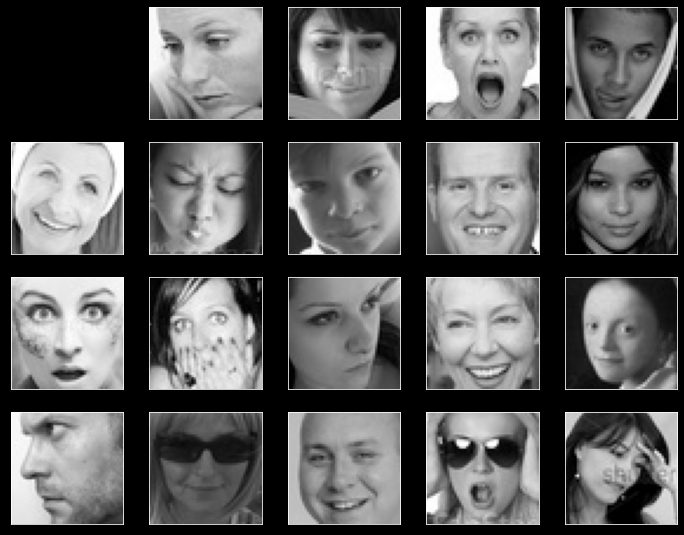

In [9]:
plot_images(train_dir)


### calling the plot_images function by passing `test_dir` as path

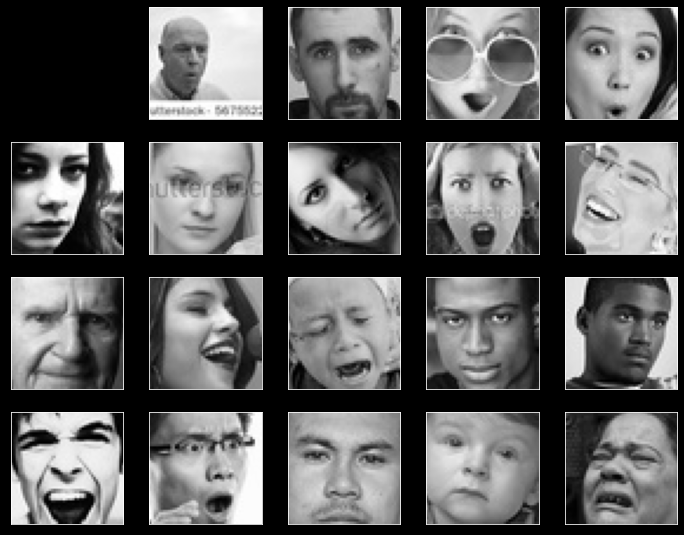

In [10]:
plot_images(test_dir)

### Function for displaying the emotion according to the expression passing as argument

In [11]:
def plot_image_acc_emotion(face_exp):
    plt.figure(figsize= (12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img(face_dir+"/train/"+face_exp+"/"+
                      os.listdir(face_dir + "/train/" + face_exp)[i], target_size=(image_size, image_size))
        plt.imshow(img)   
    plt.show()

### PLot the images based on the emotion 'happy' which is of highest number 

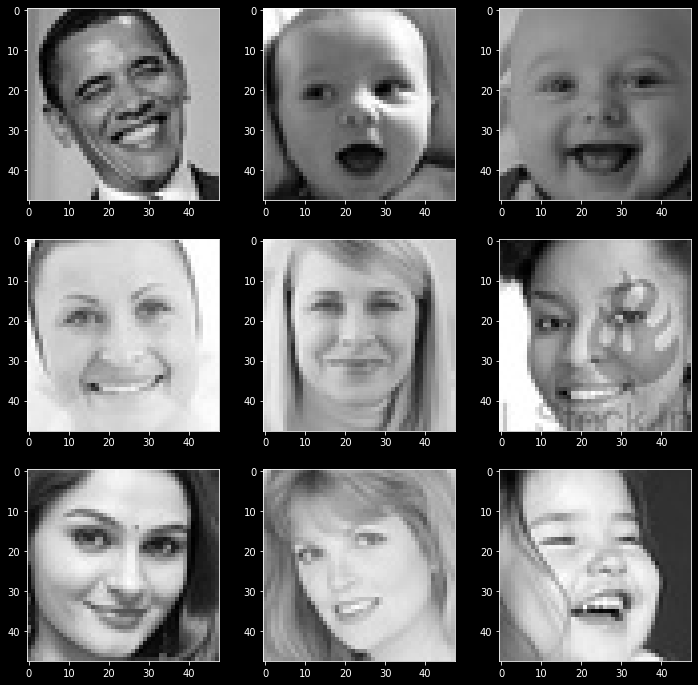

In [12]:
plot_image_acc_emotion('happy')

### PLot the images based on the emotion 'fear'

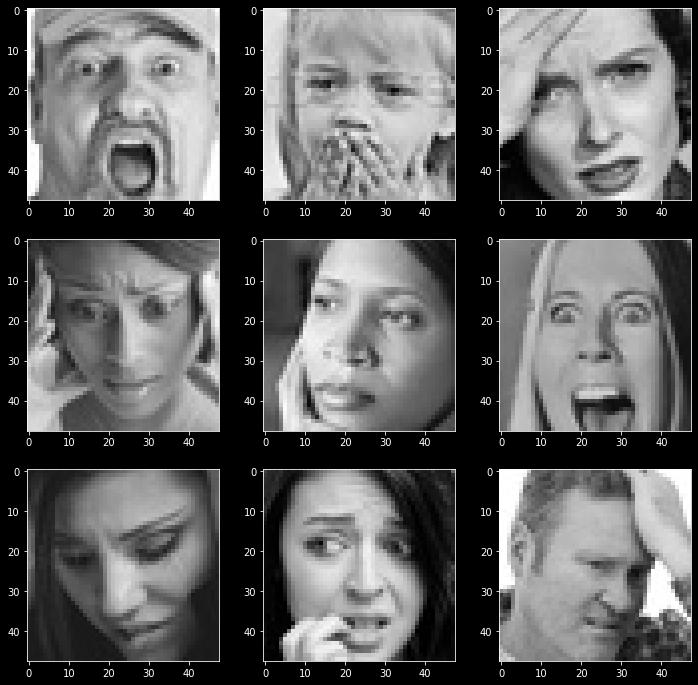

In [13]:
plot_image_acc_emotion('fear')

## Data Augmentation

### Total Images of different emotions varies, So, to balance the data, imagedatagenerator is used through which, new images will be generated according to the parameters. In training set , I split as 80:20; training:validation for testing purpose.

In [14]:
train_image_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
)

test_image_datagen = ImageDataGenerator(rescale=1./255)

### `flow_from_directory` used to read the images from the train directory path mentioned as parameter abd create two subdirectories 'training', 'validation' and stores into two different variables.

In [15]:
train_image_generator = train_image_datagen.flow_from_directory(train_dir,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical',
        color_mode = "grayscale",
        subset = 'training',                                                    
        shuffle = True)

valid_image_generator = train_image_datagen.flow_from_directory(train_dir,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical',
        color_mode = "grayscale",
        subset = 'validation' ,                                                       
        shuffle = False)


Found 23060 images belonging to 7 classes.
Found 5761 images belonging to 7 classes.


### `flow_from_directory` used to read the images from the test directory path mentioned as parameter.

In [16]:
test_image_generator = test_image_datagen.flow_from_directory(test_dir,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical',
        color_mode = "grayscale")

Found 7066 images belonging to 7 classes.


In [17]:
classes = 7                # no of classes in the training set
model = Sequential([
        # Input layer
        Conv2D(32, (3,3), padding='valid', activation='relu', input_shape=(48, 48, 1)),
        BatchNormalization(),
        Dropout(0.2), 
             
        # CNN Layers
        Conv2D(64, (3,3), padding='valid', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),
        

        Flatten(),
        
        #Fully_Connected Layers
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
    
        # Output Layer
        Dense(classes, activation='softmax')
])

2022-04-21 16:47:31.483630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-21 16:47:31.483783: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-21 16:47:31.483814: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-04-21 16:47:31.484599: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
checkpoint = ModelCheckpoint("./face_emotion.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

In [19]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer= Adam(learning_rate = 0.01))

In [ ]:
epochs = 30
history = model.fit(train_image_generator, 
                    epochs=epochs,
                    validation_data = valid_image_generator,
                    callbacks = callbacks_list)

Epoch 1/30
181/181 [==============================] - 152s 830ms/step - loss: 1.9062 - accuracy: 0.3113 - val_loss: 1.7698 - val_accuracy: 0.2899 - lr: 0.0100
Epoch 2/30
173/181 [===========================>..] - ETA: 6s - loss: 1.5968 - accuracy: 0.3865

In [17]:
classes = 7                # no of classes in the training set
deep_model = Sequential([
        # Input layer
        Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(48, 48, 1)),
        BatchNormalization(),
        Dropout(0.2), 
             
        # CNN Layers
        Conv2D(128, (5,5), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),
        
        Conv2D(512, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),
    
        Conv2D(512, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),
        

        Flatten(),
        
        #Fully_Connected Layers
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
    
         Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
    
        # Output Layer
        Dense(classes, activation='softmax')
])

2022-04-21 16:55:47.990156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-21 16:55:47.990196: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-21 16:55:47.990222: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-04-21 16:55:47.990472: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
checkpoint = ModelCheckpoint("./face_emotion.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

In [19]:
epochs = 30
deep_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer= Adam(learning_rate = 0.01))

In [ ]:
history = deep_model.fit(train_image_generator, 
                    epochs=epochs,
                    validation_data = valid_image_generator,
                    callbacks = callbacks_list)

Epoch 1/30
181/181 [==============================] - 1482s 8s/step - loss: 2.0282 - accuracy: 0.2496 - val_loss: 2.3404 - val_accuracy: 0.1465 - lr: 0.0100
Epoch 2/30
181/181 [==============================] - 1467s 8s/step - loss: 1.6735 - accuracy: 0.3715 - val_loss: 2.2138 - val_accuracy: 0.1974 - lr: 0.0100
Epoch 3/30
181/181 [==============================] - 1470s 8s/step - loss: 1.4552 - accuracy: 0.4542 - val_loss: 1.4275 - val_accuracy: 0.4551 - lr: 0.0100
Epoch 4/30
181/181 [==============================] - 1466s 8s/step - loss: 1.2775 - accuracy: 0.5087 - val_loss: 1.5828 - val_accuracy: 0.4518 - lr: 0.0100
Epoch 5/30
181/181 [==============================] - 1473s 8s/step - loss: 1.0513 - accuracy: 0.6075 - val_loss: 1.2794 - val_accuracy: 0.5383 - lr: 0.0100
Epoch 9/30
181/181 [==============================] - 1482s 8s/step - loss: 0.9729 - accuracy: 0.6334 - val_loss: 1.1561 - val_accuracy: 0.5765 - lr: 0.0100
Epoch 10/30
181/181 [==============================] - 148

In [22]:
test_loss, test_accuracy = deep_model.evaluate(test_image_generator)
print("test_loss: %f, test_accuracy: %f" % (test_loss, test_accuracy))

56/56 [==============================] - 83s 1s/step - loss: 1.1210 - accuracy: 0.5860
test_loss: 1.121013, test_accuracy: 0.586046
